# DICOM Files and Medical Image Rendering

## Introduction

In this notebook we will discuss what is a DICOM file and how to work with them. We will also discuss basics on medical image rendering. We will cover the following points:

* What is a DICOM file, how to open, read and use the information in the file
* Image Rendering and the effect of reducing the encoding bits on the image

## DICOM

DICOM is the most popular standard used in medicine for image exchange. The name is derived from **D**igital **I**maging and **CO**mmunication in **M**edicine. It allows to have medical information in the images as a standard file that is independent from the manufacturer. This means that it is possible to have images from MR scanners made by a GE system and display it in a picture archive system (PACS) from Agfa without any loss or without need of any proprietary information. It also allows opening the image in MATLAB, Python or any language without need to know how GE formatted the image file.

We will open here a DICOM image and see some of the information that is stored in the header of the image. 

Python provides some tools for DICOM image opening in the package PyDICOM.

The current Azure release will likely be missing this package, so we will install it every time using a command line. For this, we will use a command line as follows:

## Opening DICOM for metadata

We can now use the package to open a DICOM file. 

In [1]:
!pip install pydicom

In [2]:
# As usual we will have the magic command for figures inline, but you can use interactive nbagg if you prefer
%matplotlib inline

# And we will start by importing the numerical and ploting packages
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# As well as the DICOM package
import pydicom

# Get file
RefDs = pydicom.read_file('Source Files/IM_0028.dcm')

# Let's print all the Metadata here
print(RefDs)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 204
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: MR Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.46.670589.11.3397498352.605445821.304410668.1378834227
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.3.46.670589.11.0.0.51.4.32.0
(0002, 0013) Implementation Version Name         SH: 'Philips MR 32.0'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'M_SE', 'M', 'SE']
(0008, 0012) Instance Creation Date              DA: '20120101'
(0008, 0013) Instance Creation Time              TM: '122531'
(0008, 0014) Instance Creator UID                UI: 1.3.46.670589.11.2501

You can browse through that Metadata and see all the information about this image. There is a lot of information but we can already easily find out much about this image without having to know much about the specific acquisition details. It is clear  this is a **Magnetic Resonance Image** made with a **Philips scanner**.

### Activity 1 - From browsing the metadata, answer the following questions and write your answer in a different color in this markdown cell. You should include the field information [i.e. (####, ####)]

* What is the size in pixels of the image? 
#### <span style="color:blue">262,144 Pixels</span>. ####

* There are two fields with information about bits used for the image, find them

#### <span style="color:blue">Total Bits Allocated was 16 Bits but only 12 were stored</span>. ####
    
#### <span style="color:blue">(0028, 0100) Bits Allocated                      US: 16</span>. ####

#### <span style="color:blue">(0028, 0101) Bits Stored                         US: 12</span>. ####


* What is the difference between those number of bits? 

#### <span style="color:blue">4 Bits</span>. ####

* What is the full name of the vendor and the model of the scanner used to do this image?


#### <span style="color:blue">The Model of the Scanner was called Achieva and it is from Philips Medical Systems </span>. ####

* When was this image taken? Is this consistent with the file date? Why would you need this field embedded in the file?

#### <span style="color:blue">The File was created on 2011-01-01 however this not consitant as the instance creation date is in 2012, you would not need that extra information since all you want is when the image was taken.</span>. ####


* Which body part was the focus of the study? 

#### <span style="color:blue">Liver</span>. ####

* Was the subject a man or a woman?
#### <span style="color:blue">Patient is a Female</span>. ####


* Can you find the patient name in this particular example? Why?

#### <span style="color:blue">Patients Name is unkown as the pn value is empty as seen by the file '(0010, 0010) Patient's Name                      PN: '''</span>. ####


## Using DICOM metadata
Let's use code to access the metadata information simply by using the variable

In [4]:
from datetime import datetime   #used to format dates

print('The image is '+str(RefDs.Rows)+'x'+str(RefDs.Columns)+' pixels')
print('The image was encoded with '+str(RefDs.BitsStored)+' bits ')
print('The manufacturer is '+str(RefDs.Manufacturer)+' and the model is '+str(RefDs.ManufacturerModelName))
d=datetime.strptime(RefDs.AcquisitionDate,'%Y%m%d')
print('The image was made on '+str(d.date()))
print('The anatomy imaged is '+str(RefDs.BodyPartExamined))
if RefDs.PatientSex=='F':
    print('The patient imaged is Female')
else:
    print('The patient imaged is Male')
if RefDs.PatientName=='':
    print('The patient\'s name is unkown')
else:
    print('The patient\'s name is '+str(RefDs.PatientsName))

The image is 512x512 pixels
The image was encoded with 12 bits 
The manufacturer is Philips Medical Systems and the model is Achieva
The image was made on 2011-01-01
The anatomy imaged is LIVER
The patient imaged is Female
The patient's name is unkown


## Image Rendering

Image rendering is related to all and any of the techniques that are used to show an image to the user. This may require some conditioning of the image such as enhancing and restoring the image after noise removal or simply adapting the visualization of the image to the display that is available (for instance, we may require to change and smooth the image to make use of all the dynamics of a particular screen, or use a logarithmic transform on the image so the user can see details just as we did in the Fourier notebook before for the spatial spectrum).

Let's now then render the image from the information in the DICOM file. First, we need to dimension an array with all the pixels in the image. Then, we can load the information from the file and then show the image.

(0.0, 511.0, 0.0, 511.0)

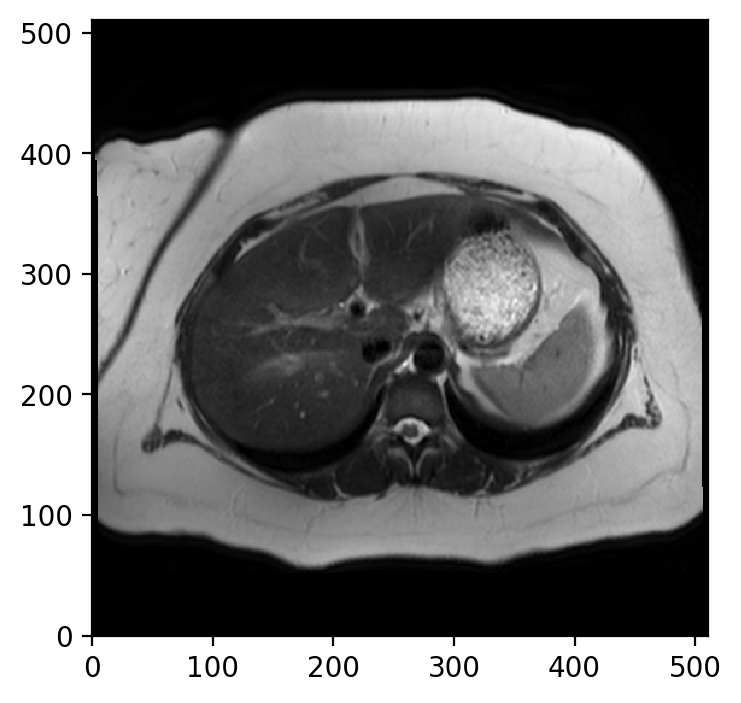

In [7]:
# To obtain the dimensions of the array to store the image we will use the metadata
ConstPixelDims = (int(RefDs.Rows), int(RefDs.Columns))

# Then initialize in zeros an array
ArrayDicom = np.zeros(ConstPixelDims, dtype=RefDs.pixel_array.dtype)

# Finally we had already read the file and we have the image information in the pixel_array (final field)
ArrayDicom[:,:]=RefDs.pixel_array

# Some rendering tools here to set the size of that image to a specific value dpi and equal axis or square image as well
# as work with grayscale

#---------Changed Code---------
# fig=plt.figure(figsize=(4, 4), dpi= 100, facecolor='w', edgecolor='b')
fig=plt.figure(figsize=(4, 4), dpi= 200, facecolor='w', edgecolor='b')


plt.axes().set_aspect('equal') #this makes the image square
plt.set_cmap(plt.gray()) #grayscale

# We could directly show the image using imshow as in the last notebook, but we can use a more traditional took using 
# colormesh (plotting 2D) 
# I chose colormesh since imshow already introduces default rendering that would not require aspect or grayscale

# Colormesh will require a horizontal and vertical axes
Rows=np.arange(RefDs.Rows)
Columns=np.arange(RefDs.Columns)

# This is the actual rendering
plt.pcolormesh(Rows, Columns, np.flipud(ArrayDicom[:, :]))

# And definition of the axes values
plt.axis([Rows.min(),Rows.max(),Columns.min(),Columns.max()])

### Activity 2 - Change in the code values for the rendering (size of the image, dpi, frame color). Are any of those impacting your ability to interpret the image? Comment the old code so I can see what you changed.

The DPI is the only thing that would increase the clarity of the image as size still uses the same amount of pixels however the pixel density (pixels per area) gets affected by the dpi settings.

### Activity 3 - When rendering the image the code flipped the array, add below a cell that renders the image without that flip but with the same rendering as before. 
#### Q1. Why did we need that flip? 
The Flip is needed becuase the images top is at the bottom of the image
#### Q2. How can you infer where is the anterior/posterior in this patient? 
Patient is Anterior

(0018, 5100) Patient Position                    CS: 'HFS'

HFS Stands for Head First Supine

#### Q3. How can you inter the left/right side? 

On the Left Side of the Body 

Both negative indicate that it is in the lower left side

(0020, 0032) Image Position (Patient)            DS: [-180.72742462158, -227.5, 64.1605377197265]

#### Q4. What in the metadata gives you information on the orientation of the patient
To get the data for Left/Right used

(0020, 0032) Image Position (Patient)            DS: [-180.72742462158, -227.5, 64.1605377197265]


To get data for Anterior/Posterior is this

(0018, 5100) Patient Position                    CS: 'HFS'

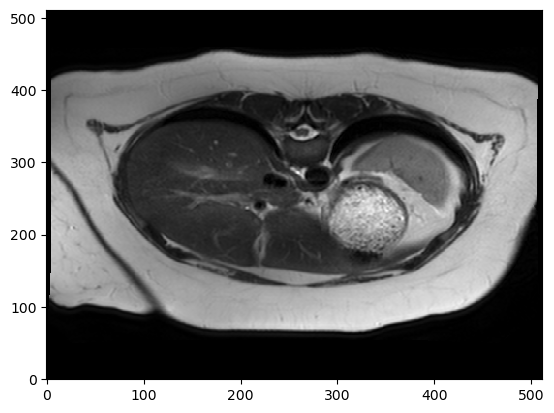

In [9]:
# This is the actual rendering without the flip
plt.pcolormesh(Rows, Columns, (ArrayDicom[:, :]))

## Image Encoding

One of the main situations we encounter when rendering an image is a difference in the amount of bit encoding that was used for an image. For instance, we may have an image that was encoded by an MRI or a CT using 12 bits but it was later converted into a JPG or PNG file and necessarily lost some information because these techniques will use only 8 bits per pixel.

We will study here the effect that encoding can have in the rendering of an image by presenting the changes on the observed image at different bit encodings. 

/var/folders/tm/sspyv08j21q74x7dxt8th_l00000gn/T/ipykernel_8943/1208904640.py:18: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  bp=plt.subplot(221)


Text(0.5, 1.0, 'Encoded at 3 bits Max=7')

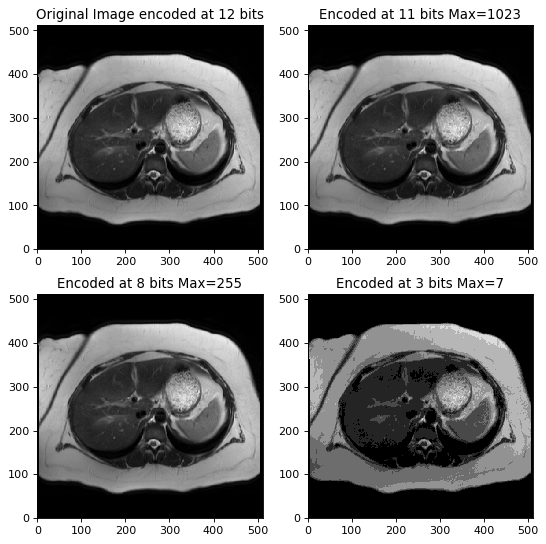

In [14]:
fig=plt.figure(figsize=(8, 8), dpi= 80, facecolor='w', edgecolor='b')
plt.axes().set_aspect('equal') #this makes the image square
plt.set_cmap(plt.gray()) #grayscale

# To encode an image we will first normalize it and then multiply by the maximum value allowed by the encoding scheme
# Ensuring that we convert into float
NormIm=1.0*ArrayDicom
NormIm=NormIm/np.max(ArrayDicom)
Im=NormIm*(pow(2,12)-1)  #original encoding at 12 bits
Im=Im.astype(int)
Jm=NormIm*(pow(2,10)-1)  #encoding at 10 bits
Jm=Jm.astype(int)
Km=NormIm*(pow(2,8)-1)  #encoding at 8 bits
Km=Km.astype(int)
Lm=NormIm*(pow(2,3)-1)  #encoding at 3 bits
Lm=Lm.astype(int)

bp=plt.subplot(221)
plt.pcolormesh(Rows, Columns, np.flipud(Im[:, :]))
plt.title('Original Image encoded at 12 bits')
plt.subplot(222)
plt.pcolormesh(Rows, Columns, np.flipud(Jm[:, :]))
plt.title('Encoded at 11 bits Max='+str(np.max(Jm)))
plt.subplot(223)
plt.pcolormesh(Rows, Columns, np.flipud(Km[:, :]))
plt.title('Encoded at 8 bits Max='+str(np.max(Km)))
plt.subplot(224)
plt.pcolormesh(Rows, Columns, np.flipud(Lm[:, :]))
plt.title('Encoded at 3 bits Max='+str(np.max(Lm)))


We can observe that we can reduce the encoding to 8 bits without much contrast loss as it would likely happen when converting into a PNG format. The main reason for the successful reduction in encoding bits without contrast loss is that the image is mostly dark and the dynamic in 8 bits is enough for the contrast to remain. However, it should be possible to reduce to 8 bits with even lower contrast loss if we use image enhancement techniques. 

In the histogram of this original image we can clearly observe that most of the information is in the black with a very high number of pixels being dark (surrounding air).

(0.0, 4096.0)

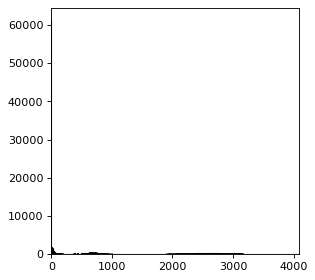

In [15]:
# This uses numpy to generate a histogram
hist,bins = np.histogram(Im.flatten(),4096,[0,4096])

fig=plt.figure(figsize=(4, 4), dpi= 80, facecolor='w', edgecolor='b')

# And we plot the histogram here for the original 12 bit image
plt.hist(Im.flatten(), 4096, [0,4096], fc='k', ec='k')
plt.xlim([0,4096])

### Activity 4 - Obtain the histograms for all the encodings below

(0.0, 256.0)

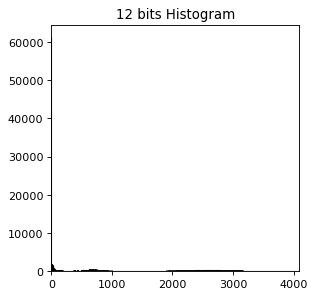

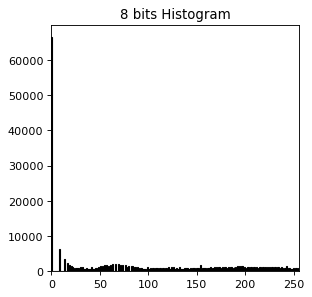

In [30]:
# Add code to obtain the histograms
# HERE
hist,bins = np.histogram(Im.flatten(),4096,[0,4096])

fig=plt.figure(figsize=(4, 4), dpi= 80, facecolor='w', edgecolor='b')
plt.title('12 bits Histogram')
# And we plot the histogram here for the original 12 bit image
plt.hist(Im.flatten(), 4096, [0,4096], fc='k', ec='k')
plt.xlim([0,4096])


## 12 Bit ^ and 8 Bit below 
hist,bins = np.histogram(Km.flatten(),256,[0,256])

fig=plt.figure(figsize=(4, 4), dpi= 80, facecolor='w', edgecolor='b')
plt.title('8 bits Histogram')
# And we plot the histogram here for the original 12 bit image
plt.hist(Km.flatten(), 256, [0,256], fc='k', ec='k')
plt.xlim([0,256])


Text(0.5, 1.0, 'Image at 8 bits - New Histogram')

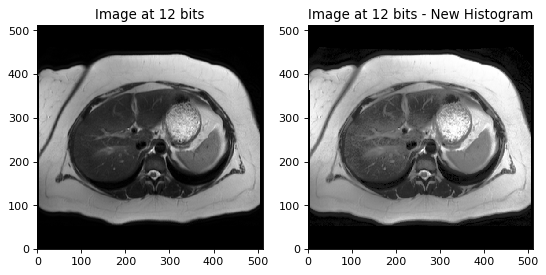

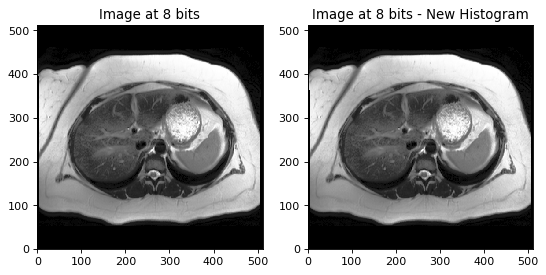

In [27]:
# This uses numpy to generate a histogram
hist,bins = np.histogram(Im.flatten(),4096,[0,4096])
cdf = hist.cumsum()         #this obtains the cumulative sum of the histogram
 
cdf = (cdf - cdf.min())*4096/(cdf.max()-cdf.min())         #and this is stretching the cumulative sum through the whole dynamic
cdf = np.ma.filled(cdf,0).astype('uint16')                 #just converting into the highest possible number of bits (16 for 12)

Im2 = cdf[Im]                                #using this as the "index" for the new image 

hist,bins = np.histogram(Im2.flatten(),4096,[0,4096])

fig=plt.figure(figsize=(8, 8), dpi= 80, facecolor='w', edgecolor='b')

plt.subplot(221)
plt.pcolormesh(Rows, Columns, np.flipud(Im[:, :]))
plt.title('Image at 12 bits')
plt.subplot(222)
plt.pcolormesh(Rows, Columns, np.flipud(Im2[:, :]))
plt.title('Image at 12 bits - New Histogram')

####ADD your code to equalize the 8-bit image
## HERE
# 2^8 is 256 which is from km 

hist,bins = np.histogram(Km.flatten(),257,[0,256])
cdf = hist.cumsum()         #this obtains the cumulative sum of the histogram
 
cdf = (cdf - cdf.min())*256/(cdf.max()-cdf.min())         #and this is stretching the cumulative sum through the whole dynamic
cdf = np.ma.filled(cdf,0).astype('uint16')                 #just converting into the highest possible number of bits (16 for 12)

Km2 = cdf[Km]                                #using this as the "index" for the new image 

hist,bins = np.histogram(Km2.flatten(),256,[0,256])

fig=plt.figure(figsize=(8, 8), dpi= 80, facecolor='w', edgecolor='b')

plt.subplot(221)
plt.pcolormesh(Rows, Columns, np.flipud(Km[:, :]))
plt.title('Image at 8 bits')
plt.subplot(222)
plt.pcolormesh(Rows, Columns, np.flipud(Km2[:, :]))
plt.title('Image at 8 bits - New Histogram')


We could get better contrast by just doing a histogram equalization as it will be done below. In this case, we are "stretching" the histogram so we can better use the dynamics. We will be equalizing the histogram for the 12-bit encoded image.

### Activity 5 - Modify the code cell to do this equalization for the 8-bit encoded image and plot all four images (the 12 bits original vs equalized and 8 bits original bs equalized). Make two observations on the images (use different colour font).

**Write here two observations on the equalization of the images**


/var/folders/tm/sspyv08j21q74x7dxt8th_l00000gn/T/ipykernel_8943/1655796560.py:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(221)


(0.0, 256.0)

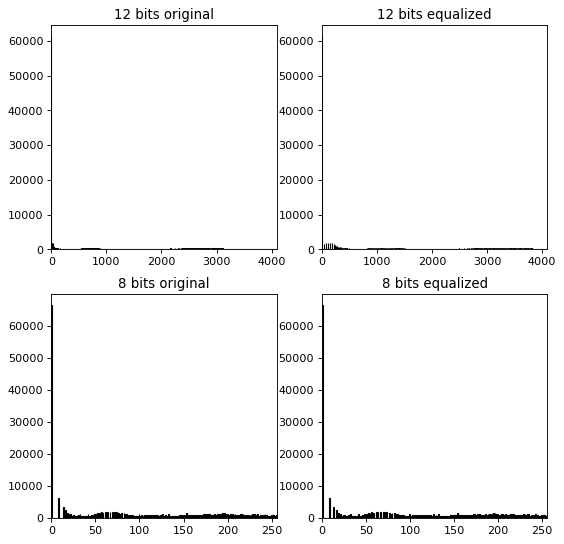

In [36]:
fig=plt.figure(figsize=(8, 8), dpi= 80, facecolor='w', edgecolor='b')
plt.axes().set_aspect('equal') #this makes the image square

# And we plot the histograms here for the original 12 bit image
plt.subplot(221)
plt.hist(Im.flatten(), 4096, [0,4096], fc='k', ec='k')
plt.title('12 bits original')
plt.xlim([0,4096])
plt.subplot(222)
plt.hist(Im2.flatten(), 4096, [0,4096], fc='k', ec='k')
plt.title('12 bits equalized')
plt.xlim([0,4096])

# Add your code for equalizing the 8 bit image histogram
# HERE
plt.subplot(223)
plt.hist(Km2.flatten(), 256, [0,256], fc='k', ec='k')
plt.title('8 bits original')
plt.xlim([0,256])
plt.subplot(224) # Plot ID
plt.hist(Km2.flatten(), 256, [0,256], fc='k', ec='k')
plt.title('8 bits equalized')
plt.xlim([0,256])


#### <span style="color:blue">Two Observations can be seen is that there appears to be more x-values when comparing the 8 bit image to the 12 bit image, the second one is the the largest y value surpases 60,000 while the 12 bit version shows less then 10,000. Lastly one more difference is seen in the 12 bits original versus the 12 bit equalized and that is there is a slope in the hisotram that is much more noticable then the prior.</span>. ####

## Summary

In this example we:

* Analyzed the impact of reducing the encoding bits in an image on the rendering to the user
* Investigated a histogram equalization technique to better use the dynamic provided by the encoding bits

Comments and corrections welcome!

## Assignment 2

* Complete the 5 Activities in the notebook and upload your notebook to your GitHub repository.
* Remember you should have given permissions to this **private** repository to your instructor.
* Please note you should upload all your code in the repository with those permissions, do not give permissions every time for new repositories.
* Submit on D2L the PDF of your notebook where the results of these activities can be seen. The backup PDF accounts for 10% of your mark. Note that full marks are only given if the code is on your repository and runs, but you can get partial marks from this PDF output if the code fails to run or is not accessible at the time of grading. No marks will be given if the date on GitHub is after the deadline.
* The following challenges **are for bonus points** and you can submit them later (up until the final exam date) 

## Challenge \# 4 - Histogram Equalization

Using the code as a guide add a markdown with equations and "Wikipedia-like" explanations on how histogram equalization works. 

<font color=green> If we define an image $$p$$

The cumulative distribution function $$ cdf(i) = \sum _{j=0}^{i}p(j) $$ 
represents the cumulated normalized histogram.

We can apply a transformation $$y = T(x)$$ to obtain an image *y* with an equalized histogram for which the cummulative normalized histogram will be linear $$cdf_{y}(i)=iK$$
with *K* being the number of bins or values that can be assigned to this image (4096 for 12 bits). 

The properties of the CDF allow us to perform such a transform using a lookup table as in the code.

</font>

## Challenge \# 5 - Interactive plot

Make an interactive rendering that provides a sliding tool to define the bits for encoding (Tip: investigate the *interact* in *ipwidgets*)

By using your interactive tools answer:
* What seems to be the minimum amount of bits to use if the contrast should be kept for the liver?
<font color=green> 5 bits </font>
* What is the organ within the abdomen for which you loose contrast first?
<font color=green> Liver </font>

In [12]:
from ipywidgets import interact

NormIm=1.0*ArrayDicom
NormIm=NormIm/np.max(ArrayDicom)

def Encoding(Bits):
    ImI=NormIm*(pow(2,Bits)-1)  
    ImI=ImI.astype(int)
    fig=plt.figure(figsize=(8, 8), dpi= 80, facecolor='w', edgecolor='b')
    plt.pcolormesh(Rows, Columns, np.flipud(ImI[:, :]))
    plt.axis('equal')
    plt.show()
            
interact(Encoding,Bits=(1,12));   #this is the actual call of the function in an interactive mode!!

interactive(children=(IntSlider(value=6, description='Bits', max=12, min=1), Output()), _dom_classes=('widget-…

References
---------------

* Tinku Acharya and Ajoy K. Ray, *Image Processing - Principles and Applications*. Wiley InterScience, 2006.